In [1]:
from pyxlma.plot.xlma_base_plot import BlankPlot
from pyxlma.plot.xlma_plot_feature import plot_glm_events, plot_points, color_by_time
from glmtools.io.glm import GLMDataset, get_lutevents
from glmtools.io.lightning_ellipse import lightning_ellipse_rev, ltg_ellpse_rev
from glmtools.io.ccd import load_pixel_corner_lookup, quads_from_corner_lookup
from glmtools.io.imagery import get_goes_imager_proj
import datetime as dt
from cartopy import crs as ccrs
from pyxlma import coords
import numpy as np
import warnings
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

In [10]:
glm_data = GLMDataset('examples/network_samples/OR_GLM-L2-LCFA_G16_s20233580057000_e20233580057200_c20233580057222.nc')
glm = glm_data.dataset
glm

<xarray.Dataset> Size: 660kB
Dimensions:                                 (number_of_events: 11094,
                                             number_of_groups: 3821,
                                             number_of_flashes: 212,
                                             number_of_time_bounds: 2,
                                             number_of_wavelength_bounds: 2,
                                             number_of_field_of_view_bounds: 2)
Coordinates: (12/21)
    event_id                                (number_of_events) uint32 44kB 16...
    event_time_offset                       (number_of_events) datetime64[ns] 89kB ...
    event_lat                               (number_of_events) float32 44kB -...
    event_lon                               (number_of_events) float32 44kB -...
    event_parent_group_id                   (number_of_events) uint32 44kB 66...
    group_id                                (number_of_groups) uint32 15kB 66...
    ...                                      ...
    product_time                            datetime64[ns] 8B 2023-12-24T00:5...
    lightning_wavelength                    float32 4B ...
    group_time_threshold                    float32 4B ...
    flash_time_threshold                    float32 4B ...
    lat_field_of_view                       float32 4B ...
    lon_field_of_view                       float32 4B -75.0
Dimensions without coordinates: number_of_events, number_of_groups,
                                number_of_flashes, number_of_time_bounds,
                                number_of_wavelength_bounds,
                                number_of_field_of_view_bounds
Data variables: (12/37)
    event_energy                            (number_of_events) float32 44kB 1...
    group_frame_time_offset                 (number_of_groups) datetime64[ns] 31kB ...
    group_area                              (number_of_groups) float32 15kB 2...
    group_energy                            (number_of_groups) float32 15kB 1...
    group_quality_flag                      (number_of_groups) float32 15kB ...
    flash_frame_time_offset_of_first_event  (number_of_flashes) datetime64[ns] 2kB ...
    ...                                      ...
    event_x                                 (number_of_events) float32 44kB 0...
    event_y                                 (number_of_events) float32 44kB -...
    group_x                                 (number_of_groups) float32 15kB 0...
    group_y                                 (number_of_groups) float32 15kB -...
    flash_x                                 (number_of_flashes) float32 848B ...
    flash_y                                 (number_of_flashes) float32 848B ...
Attributes: (12/29)
    production_site:           WCDAS
    featureType:               point
    dataset_name:              OR_GLM-L2-LCFA_G16_s20233580057000_e2023358005...
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    institution:               DOC/NOAA/NESDIS> U.S. Department of Commerce, ...
    ...                        ...
    time_coverage_start:       2023-12-24T00:57:00.0Z
    time_coverage_end:         2023-12-24T00:57:20.0Z
    production_data_source:    Realtime
    production_environment:    OE
    LUT_Filenames:             GLM_CALINR_AllFilters(FM1E_CDRL79RevK_DO_09_00...
    id:                        a4140f6a-9068-4f60-a714-5cc0a5218f56

In [3]:
ltg_ellipse_params = lightning_ellipse_rev[ltg_ellpse_rev(glm.product_time.data.astype('datetime64[s]'))]
satsys_ltg_750 = coords.GeostationaryFixedGridSystem(glm.lon_field_of_view.data, sat_ecef_height=glm.nominal_satellite_height.data*1000,
                                                 sweep_axis='x', ellipse=list(ltg_ellipse_params))
geosys = coords.GeographicSystem()
evt_ecef_coords = satsys_ltg_750.toECEF(glm.event_x.data, glm.event_y.data, np.zeros_like(glm.event_x.data))
evt_lon_750, evt_lat_750, _ = geosys.fromECEF(*evt_ecef_coords)

In [4]:
unique_ds = get_lutevents(glm)
evrad = unique_ds.lutevent_energy

x_lut, y_lut, corner_lut = load_pixel_corner_lookup()
x_lut = x_lut * 1.0e-6
y_lut = y_lut * 1.0e-6
corner_lut = corner_lut*1e-6

event_polys = quads_from_corner_lookup(x_lut, y_lut, corner_lut,
unique_ds.lutevent_x, unique_ds.lutevent_y)

glm['lutevent_corner_x'] = xr.DataArray(event_polys[:,:,0], dims=['lutevent_id', 'number_of_corners'])
glm['lutevent_corner_y'] = xr.DataArray(event_polys[:,:,1], dims=['lutevent_id', 'number_of_corners'])
evt_corner_x = glm.lutevent_corner_x.data
evt_corner_y = glm.lutevent_corner_y.data
evt_corner_z = np.zeros_like(evt_corner_x)

In [5]:
evt_corner_ecef = satsys_ltg_750.toECEF(evt_corner_x, evt_corner_y, evt_corner_z)
evt_corner_lon, evt_corner_lat, _ = geosys.fromECEF(*evt_corner_ecef)
evt_corner_lon = evt_corner_lon.reshape(evt_corner_x.shape)
evt_corner_lat = evt_corner_lat.reshape(evt_corner_y.shape)

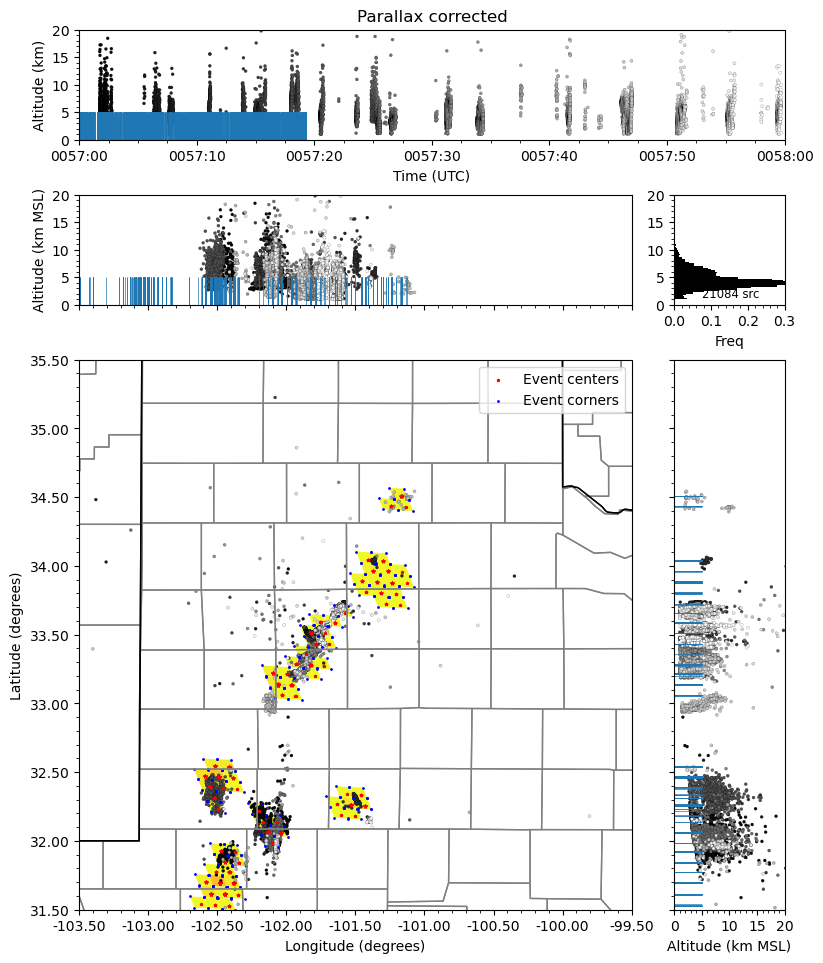

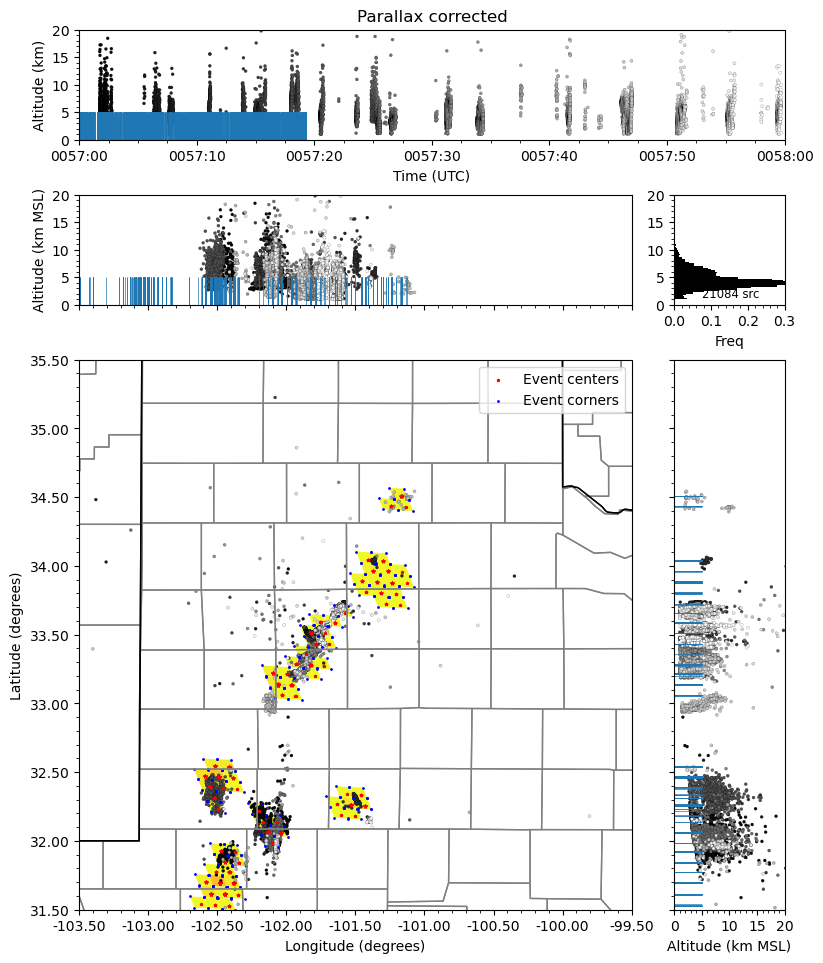

In [13]:
start_time = dt.datetime(2023, 12, 24, 0, 57, 0, 0)
end_time = start_time + dt.timedelta(seconds=60)
bk_plot = BlankPlot(start_time, bkgmap=True, xlim=[-103.5, -99.5], ylim=[31.5, 35.5], zlim=[0, 20], tlim=[start_time, end_time], title='Parallax corrected')

plot_glm_events(glm_data.dataset, bk_plot, fake_alt=[0, 0.25], poly_kwargs={'cmap' : 'plasma_r'}, vlines_kwargs={'linewidths' : 0.5}, should_parallax_correct=True)
start_time = dt.datetime(2023, 12, 24, 0, 57, 0, 0)
end_time = start_time + dt.timedelta(seconds=60)
dataset = xr.open_dataset('tests/truth/lma_netcdf/lma.nc')
times = pd.Series(dataset.event_time.data.flatten())
vmin, vmax, colors = color_by_time(pd.to_datetime(times), (start_time, end_time))
plot_points(bk_plot, dataset.event_longitude.data, dataset.event_latitude.data, dataset.event_altitude.data/1000,
            dataset.event_time.data, cmap='gray', s=5, vmin=vmin, vmax=vmax,
            c=colors, edgecolors='k', linewidths=0.1, add_to_histogram=True)
bk_plot.ax_plan.scatter(glm.event_lon, glm.event_lat, c='r', s=3, marker='*', transform=ccrs.PlateCarree(), label='Event centers')
bk_plot.ax_plan.scatter(evt_corner_lon, evt_corner_lat, c='b', s=1, transform=ccrs.PlateCarree(), label='Event corners')
bk_plot.ax_plan.legend()
bk_plot.fig